In [1]:
import torch.nn as nn
import numpy as np
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import mnist
from torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
class Net(nn.Module):
    def __init__(self, in_c=784, out_c=10):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(in_c, 512)
        self.act1 = nn.ReLU(inplace=True)

        self.fc2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU(inplace=True)

        self.fc3 = nn.Linear(256, 128)
        self.act3 = nn.ReLU(inplace=True)

        self.fc4 = nn.Linear(128, out_c)

    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = self.act3(self.fc3(x))
        x = self.fc4(x)
        return x

In [3]:
# 构建网络
net = Net()

# 准备数据集
train_set = mnist.MNIST(
    "./data", train=True, transform=transforms.ToTensor(), download=True
)
test_set = mnist.MNIST(
    "./data", train=False, transform=transforms.ToTensor(), download=True
)

train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)

100%|██████████| 9912422/9912422 [01:47<00:00, 92433.37it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:01<00:00, 27605.27it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:06<00:00, 237156.12it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 13493.97it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



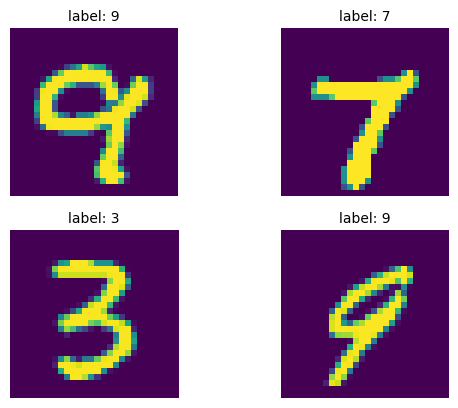

In [7]:
import random

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    idx = random.randint(0, len(train_set))
    digit_0 = train_set[idx][0].numpy()
    digit_0_image = digit_0.reshape(28, 28)
    ax.imshow(digit_0_image, interpolation="nearest")
    ax.set_title("label: {}".format(train_set[idx][1]), fontsize=10, color="black")
    ax.axis("off")

plt.show()

[INFO] Epoch-1-Batch-200: Train: Loss-2.2834, Accuracy-0.1875
[INFO] Epoch-1-Batch-400: Train: Loss-2.2631, Accuracy-0.4531
[INFO] Epoch-1-Batch-600: Train: Loss-2.1913, Accuracy-0.6719
[INFO] Epoch-1-Batch-800: Train: Loss-2.0199, Accuracy-0.7188
[INFO] Epoch-1: Train: Loss-2.1867, Accuracy-0.4446 | Test: Loss-1.7243, Accuracy-0.6717
[INFO] Epoch-2-Batch-200: Train: Loss-1.1701, Accuracy-0.6094
[INFO] Epoch-2-Batch-400: Train: Loss-0.9219, Accuracy-0.7188
[INFO] Epoch-2-Batch-600: Train: Loss-0.7130, Accuracy-0.8281
[INFO] Epoch-2-Batch-800: Train: Loss-0.6600, Accuracy-0.7812
[INFO] Epoch-2: Train: Loss-0.8484, Accuracy-0.7831 | Test: Loss-0.4873, Accuracy-0.8597
[INFO] Epoch-3-Batch-200: Train: Loss-0.5087, Accuracy-0.8594
[INFO] Epoch-3-Batch-400: Train: Loss-0.3861, Accuracy-0.8750
[INFO] Epoch-3-Batch-600: Train: Loss-0.3928, Accuracy-0.8906
[INFO] Epoch-3-Batch-800: Train: Loss-0.4480, Accuracy-0.8750
[INFO] Epoch-3: Train: Loss-0.4329, Accuracy-0.8750 | Test: Loss-0.3726, Accur

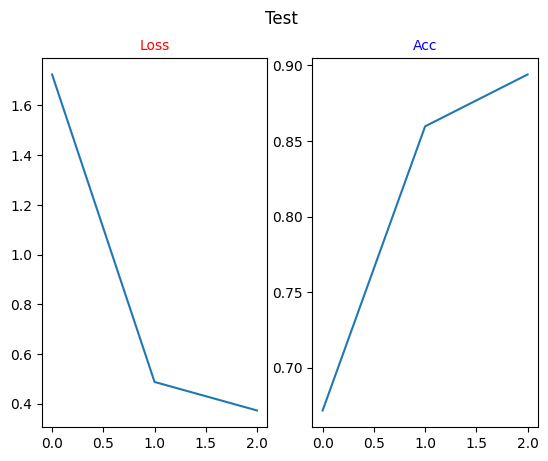

In [5]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.SGD(net.parameters(), lr=1e-2, weight_decay=5e-4)

# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []
num_epoch = 3

for epoch in range(num_epoch):
    train_loss = 0
    train_acc = 0
    net = net.train()
    for batch, (img, label) in enumerate(train_data):
        img = img.reshape(img.size(0), -1)
        img = Variable(img)
        label = Variable(label)

        # 前向传播
        out = net(img)
        loss = criterion(out, label)

        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]

        if (batch + 1) % 200 == 0:
            print(
                "[INFO] Epoch-{}-Batch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f}".format(
                    epoch + 1, batch + 1, loss.item(), acc
                )
            )
        train_acc += acc

    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))

    eval_loss = 0
    eval_acc = 0
    # 测试集不训练
    for img, label in test_data:
        img = img.reshape(img.size(0), -1)
        img = Variable(img)
        label = Variable(label)

        out = net(img)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()

        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / img.shape[0]

        eval_acc += acc
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))

    print(
        "[INFO] Epoch-{}: Train: Loss-{:.4f}, Accuracy-{:.4f} | Test: Loss-{:.4f}, Accuracy-{:.4f}".format(
            epoch + 1,
            train_loss / len(train_data),
            train_acc / len(train_data),
            eval_loss / len(test_data),
            eval_acc / len(test_data),
        )
    )

plt.figure()
plt.suptitle("Test", fontsize=12)
ax1 = plt.subplot(1, 2, 1)
ax1.plot(eval_losses)
ax1.set_title("Loss", fontsize=10, color="r")
ax2 = plt.subplot(1, 2, 2)
ax2.plot(eval_acces)
ax2.set_title("Acc", fontsize=10, color="b")
plt.show()